# Explore data in detail
* Type
    * audio, visual , audiovisual
* file name: s[1~16]\_[A, V, AV]_[test, train].[dat, dat_1, dat_2].npz
    * [1~16] -> subject index
    * [A, V, AV] -> experiment type index
    * [test, train]
        * train: initial trial
        * test: employ trained model
* Dimension
    * 2 items ['dataEEG', 'labels']
        * dataEEG: 250 samples, 16 channel, 614 data points
        * labels: 250
* very high frequency
    * 512 Hz
    * ignore first 100 (fisrt few samples are not stable)

In [2]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import glob

audio = glob.glob("../data/sample1/audio/*")
visual = glob.glob("../data/sample1/visual/*")
both = glob.glob("../data/sample1/audiovisual/*")

### Data Files

In [3]:
def detail(data):
    print("data size:", len(data))
    d = []
    for d_ in data:
        d__ = np.load(d_)
        d.append(d__)
        print(d_.split('/')[-1], d__.keys(), [d___[1].shape for d___ in d__.items()])
    return d

d = detail(audio)

data size: 49
s10_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_test.dat_3.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s10_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s11_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s12_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_test.dat_2.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s13_A_train.dat.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s14_A_test.dat_1.npz ['labels', 'dataEEG'] [(250,), (250, 16, 614)]
s14_A_test.dat_2.npz ['labels', 'dataE

### Check the signals

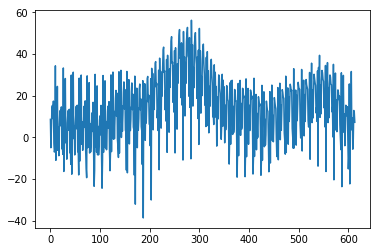

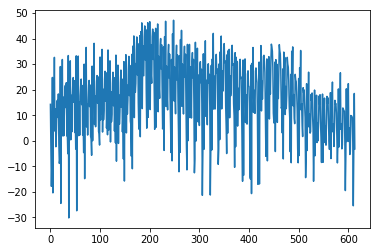

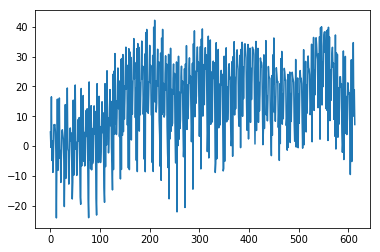

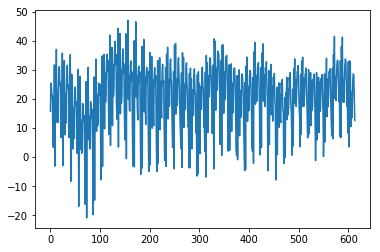

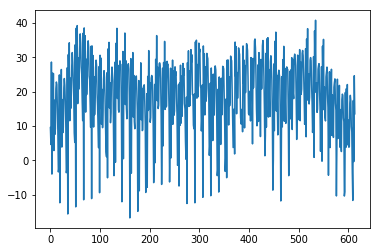

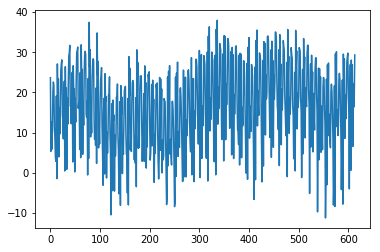

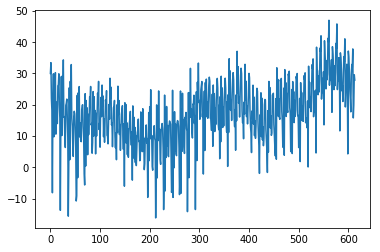

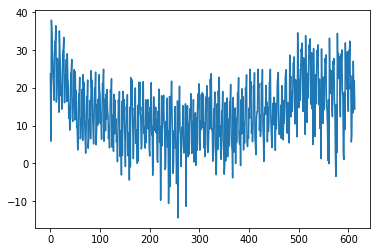

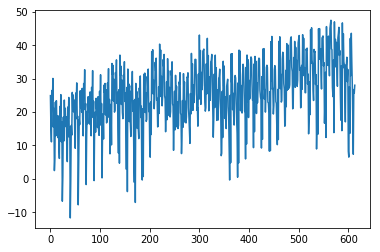

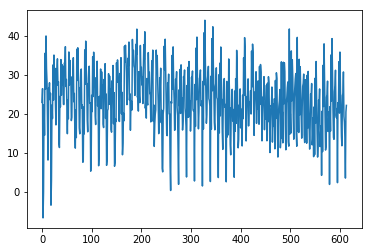

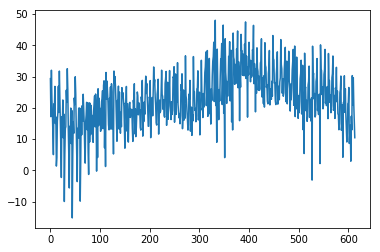

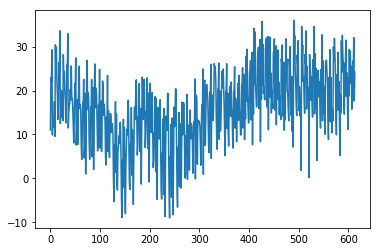

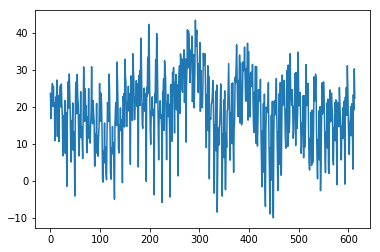

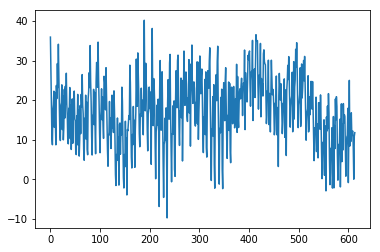

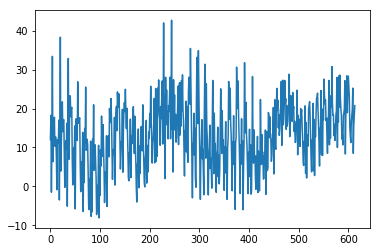

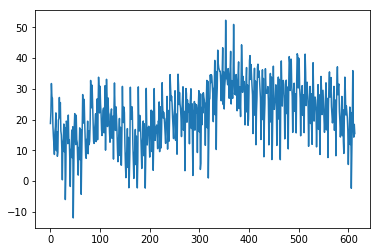

In [4]:
data = np.load(audio[0]).items()[1][1][0]
for i in range(len(data)):
    fig = plt.figure(i)
    plt.plot(data[i])
    plt.show()

### Filtering (FIR)
* Filters
    * Band pass, High pass, Low pass, High pass -> Low pass
* refference
    * Blog: http://aidiary.hatenablog.com/entry/20111102/1320241544
    * Document: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.lfilter.html
    * Cutting freq: http://www.kimura-lab.net/wp-content/uploads/2012/05/%E3%82%AB%E3%83%83%E3%83%88%E3%82%AA%E3%83%95%E5%91%A8%E6%B3%A2%E6%95%B0%E3%81%AE%E8%A8%AD%E5%AE%9A%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6.pdf

In [19]:
from functions import filtering
help(filtering)

Help on function filtering in module functions:

filtering(fil, data, nyq=None, cut_low=None, cut_high=None, numtaps=225)
    FIR Filtering
    
     Parameters
    ----------------------------------
    data: signal data
    nyq: nyquist frequency
    fil: h (high pass), l (low pass), b (band pass)
         bs (band stop), m (median)
    cut_high: cutting frequency (high pass)
    cut_low: cutting frequency (low pass)
    numstap: tap number



In [26]:
def plot_filtered(data):
    # Frequency
    fs = 512

    # Nyquist frequency
    nyq = fs / 2.0  

    # Cut off frequency
    cut_low = 1/10*nyq
    cut_high = 4/5*nyq
    print(cut_low, cut_high)

    # Filtering tup number (need to be odds)
    numtaps = 255

    # Filtering and plot
    fig = plt.figure(0)
    plt.plot(data)
    plt.title("original")

    y = filtering("m", data, numtaps=21)
    fig = plt.figure(1)
    plt.plot(y)
    plt.title("median")

    y = filtering("b", data, nyq, cut_low=cut_low, cut_high=cut_high, numtaps=numtaps)
    fig = plt.figure(2)
    plt.plot(y)
    plt.title("band pass")

    y = filtering("l", data, nyq, cut_low=cut_low, numtaps=numtaps)
    fig = plt.figure(3)
    plt.plot(y)
    plt.title("low pass")

    y = filtering("h", data, nyq, cut_high=cut_high, numtaps=numtaps)
    fig = plt.figure(4)
    plt.plot(y)
    plt.title("high pass")

    y = filtering("h", data, nyq, cut_high=cut_high, numtaps=numtaps)
    y = filtering("l", y, nyq, cut_low=cut_low, numtaps=numtaps)
    fig = plt.figure(5)
    plt.plot(y)
    plt.title("high pass -> low pass")

    plt.show()

*** Single channel signal ***

25.6 204.8


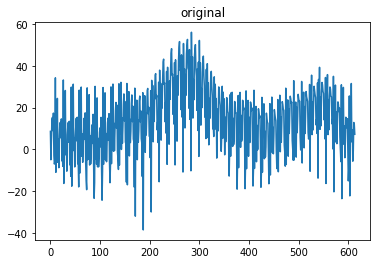

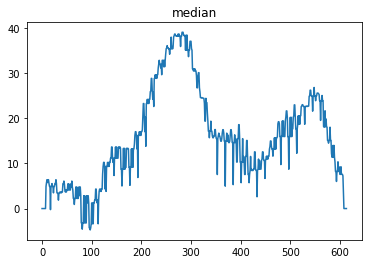

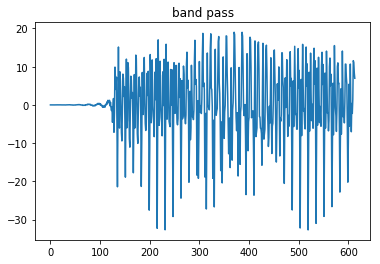

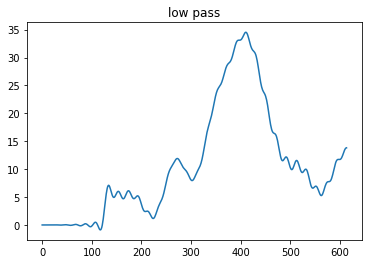

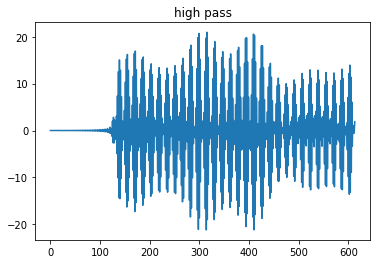

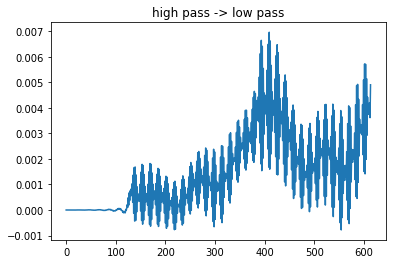

In [27]:
plot_filtered(data[0])

*** Averaging all channel signal ***

25.6 204.8


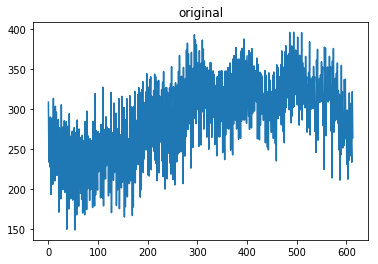

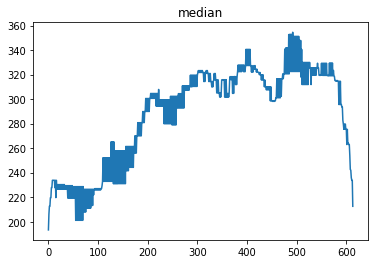

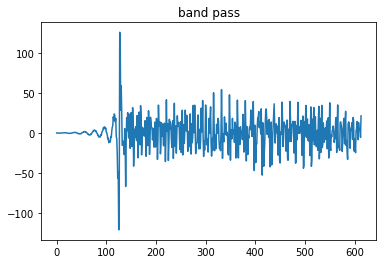

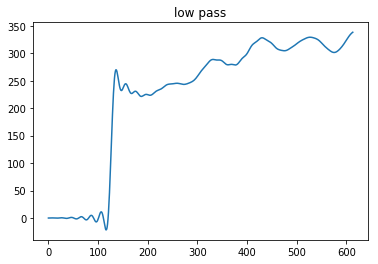

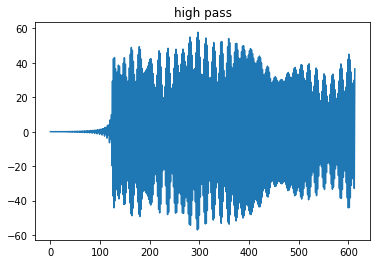

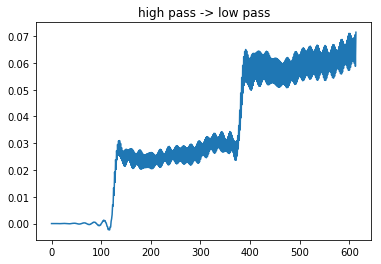

In [30]:
ave = data.sum(0)
plot_filtered(ave)